In [1]:
import torch
from dataloaders.beat import CustomDataset
from dataloaders.build_vocab import Vocab
import pickle
import numpy as np

config_file = open("gesturegen_config.obj", 'rb') 
args = pickle.load(config_file)
args.batch_size = 16

mean_facial = torch.from_numpy(np.load(args.root_path+args.mean_pose_path+f"{args.facial_rep}/json_mean.npy"))
std_facial = torch.from_numpy(np.load(args.root_path+args.mean_pose_path+f"{args.facial_rep}/json_std.npy"))
mean_audio = torch.from_numpy(np.load(args.root_path+args.mean_pose_path+f"{args.audio_rep}/npy_mean.npy"))
std_audio = torch.from_numpy(np.load(args.root_path+args.mean_pose_path+f"{args.audio_rep}/npy_std.npy"))

In [2]:
train_data = CustomDataset(args, "train")
train_loader = torch.utils.data.DataLoader(
    train_data, 
    batch_size=args.batch_size,  
    shuffle=True,  
    drop_last=True,
)

In [3]:
len(train_loader)

14857

In [4]:
val_data = CustomDataset(args, "val")
val_loader = torch.utils.data.DataLoader(
    val_data, 
    batch_size=args.batch_size,  
    shuffle=True,  
    drop_last=True,
)

In [5]:
len(val_loader)

2972

### Test A2BS SimpleNet

In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from scripts.Dataset import a2bsDataset
from scripts.MulticontextNet import GestureGen
#import wandb
import uuid

In [7]:
# project = "testing"
# group = "facegenerator"
# name = "test"
# dataset_name = "beat"
# entity = "hm_gesture"
# run = wandb.init(
#         project="testing",
#         group="facegenerator",
#         name= f"{name}-{dataset_name}-{str(uuid.uuid4())[:8]}",
#         id=str(uuid.uuid4()),
#         entity=entity,
#     )
# wandb.run.save()

In [8]:
net = GestureGen(args).cuda()
optimizer = torch.optim.Adam( net.parameters(), lr=1e-4)#, weight_decay=1e-5)
train_target_loss = []
train_expressive_loss = []
train_smooth_loss = []
train_mse_loss = []
val_target_loss = []
val_expressive_loss = []
val_smooth_loss = []
val_mse_loss = []

def plot_train_val_loss():
    fig, axs = plt.subplots(1, 4, figsize=(15, 5))
    axs[0].plot(train_target_loss, 'r-')
    axs[0].set_title('Target Loss')
    axs[1].plot(train_expressive_loss, 'p-')
    axs[1].set_title('Expressive Loss')
    axs[2].plot(train_smooth_loss, 'g-')
    axs[2].set_title('Smooth Loss')
    axs[3].plot(train_mse_loss, 'b-')
    axs[3].set_title('MSE Loss')
    fig.suptitle('Training Iterations', fontsize = 16)
    plt.tight_layout()
    plt.show()

    fig, axs = plt.subplots(1, 4, figsize=(15, 5))
    axs[0].plot(val_target_loss, 'r-')
    axs[0].set_title('Target Loss')
    axs[1].plot(val_expressive_loss, 'p-')
    axs[1].set_title('Expressive Loss')
    axs[2].plot(val_smooth_loss, 'g-')
    axs[2].set_title('Smooth Loss')
    axs[3].plot(val_mse_loss, 'b-')
    axs[3].set_title('MSE Loss')
    fig.suptitle('Validation Iterations', fontsize = 16)
    plt.tight_layout()
    plt.show()

In [10]:
print(len(train_data))
data = next(iter(train_loader))
in_audio = data['audio']
facial = data['facial']
in_id = data["id"]
in_word = data["word"]
in_emo = data["emo"]

237714


In [11]:
def expressive_loss_function(output, target): # max squared error over blendshape for each frame, then take the mean
    loss = torch.mean(torch.max((output - target) ** 2, dim=-1).values)
    return loss
# a = torch.tensor([[[1,2,3],[1,2,3]],[[4,5,6],[4,5,6]]]).float()
# b = torch.tensor([[[3,3,4],[2,3,4]],[[5,6,7],[5,6,7]]]).float()
# print(a.shape)
# max_square_error(a, b)

In [12]:
from tqdm import tqdm
num_epochs = 20
log_period = 200
val_period = 600
val_size = 25
target_loss_function = torch.nn.HuberLoss()
smooth_loss_function = torch.nn.CosineSimilarity(dim=2)
mse_loss_function = torch.nn.MSELoss()
target_weight = 1.5
expressive_weight = 0.5
smooth_weight = 0.5

for epoch in range(num_epochs):
    for it, data in enumerate(tqdm(train_loader)):
        net.train()
        in_audio = data['audio']
        facial = data['facial']
        in_id = data["id"]
        in_word = data["word"]
        in_emo = data["emo"]

        in_audio = in_audio.cuda()
        facial = facial.cuda()
        in_id = in_id.cuda()
        in_word = in_word.cuda()
        in_emo = in_emo.cuda()

        pre_frames = 4
        in_pre_face = facial.new_zeros((facial.shape[0], facial.shape[1], facial.shape[2] + 1)).cuda()
        in_pre_face[:, 0:pre_frames, :-1] = facial[:, 0:pre_frames]
        in_pre_face[:, 0:pre_frames, -1] = 1 
        
        optimizer.zero_grad()
        out_face = net(in_pre_face,in_audio=in_audio,in_text=in_word, in_id=in_id, in_emo=in_emo)
        target_loss = target_loss_function(out_face, facial)
        expressive_loss = expressive_loss_function(out_face, facial)
        smooth_loss = 1 - smooth_loss_function(out_face[:,:-1,:], out_face[:,1:,:]).mean()
        loss = target_weight * target_loss + expressive_weight * expressive_loss + smooth_weight * smooth_loss
        loss.backward()
        optimizer.step()
        
        train_target_loss.append(target_loss.item())
        train_expressive_loss.append(expressive_loss.item())
        train_smooth_loss.append(smooth_loss.item())
        train_mse_loss.append(mse_loss_function(out_face.cpu()*std_facial+mean_facial, facial.cpu()*std_facial+mean_facial).item())
        
        #logging
        if it % log_period == 0:
            print(f'[{epoch}][{it}/{len(train_loader)}]: [train] [target loss]: {train_target_loss[-1]} [exp loss]: {train_expressive_loss[-1]} [smooth loss]: {train_smooth_loss[-1]} [mse]: {train_mse_loss[-1]}')
        
        if it % val_period == 0:
            net.eval()
            val_target_loss_st = []
            val_expressive_loss_st = []
            val_smooth_loss_st = []
            val_mse_loss_st = []
            val_cnt = 0
            
            for _, data in enumerate(val_loader):
                in_audio = data['audio']
                facial = data['facial']
                in_id = data["id"]
                in_word = data["word"]
                in_emo = data["emo"]

                in_audio = in_audio.cuda()
                facial = facial.cuda()
                in_id = in_id.cuda()
                in_word = in_word.cuda()
                in_emo = in_emo.cuda()

                pre_frames = 4
                in_pre_face = facial.new_zeros((facial.shape[0], facial.shape[1], facial.shape[2] + 1)).cuda()
                in_pre_face[:, 0:pre_frames, :-1] = facial[:, 0:pre_frames]
                in_pre_face[:, 0:pre_frames, -1] = 1 

                out_face = net(in_pre_face,in_audio=in_audio,in_text=in_word, in_id=in_id, in_emo=in_emo)
                target_loss = target_loss_function(out_face, facial) 
                expressive_loss = expressive_loss_function(out_face, facial)
                smooth_loss = 1 - smooth_loss_function(out_face[:,:-1,:], out_face[:,1:,:]).mean()

                val_target_loss_st.append(target_loss.item())
                val_expressive_loss_st.append(expressive_loss.item())
                val_smooth_loss_st.append(smooth_loss.item())
                val_mse_loss_st.append(mse_loss_function(out_face.cpu()*std_facial+mean_facial, facial.cpu()*std_facial+mean_facial).item())
                
                
                val_cnt += 1
                if val_cnt >= val_size:
                    break
            
            val_target_loss.append(np.average(val_target_loss_st))
            val_expressive_loss.append(np.average(val_expressive_loss_st))
            val_smooth_loss.append(np.average(val_smooth_loss_st))
            val_mse_loss.append(np.average(val_mse_loss_st))
            print(f'[{epoch}][{it}/{len(train_loader)}]: [val] [target loss]: {val_target_loss[-1]} [exp loss]: {val_expressive_loss[-1]} [smooth loss]: {val_smooth_loss[-1]} [mse]: {val_mse_loss[-1]}')
    plot_train_val_loss()
        

  0%|          | 0/14857 [00:00<?, ?it/s]

  0%|          | 0/14857 [00:02<?, ?it/s]

[0][0/14857]: [train] [target loss]: 0.3342486321926117 [exp loss]: 9.598690032958984 [smooth loss]: 0.03145551681518555 [mse]: 0.011159439918450557


TypeError: embedding(): argument 'indices' (position 2) must be Tensor, not NoneType

In [20]:
torch.save(net.state_dict(), 'ckpt_model/simplenet3.pth')

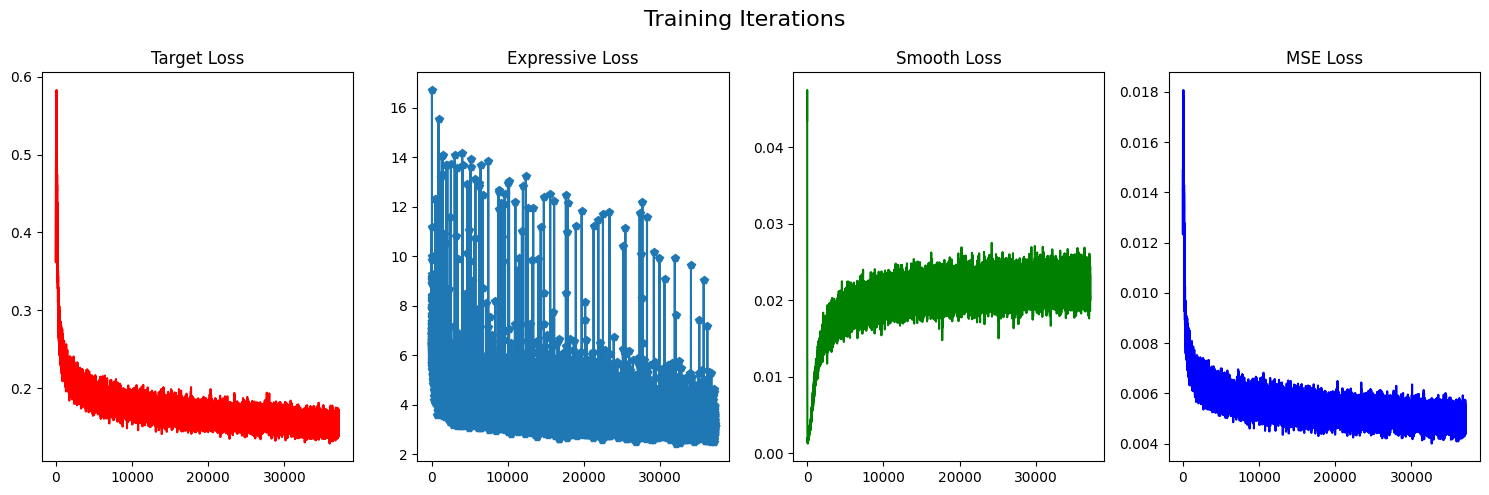

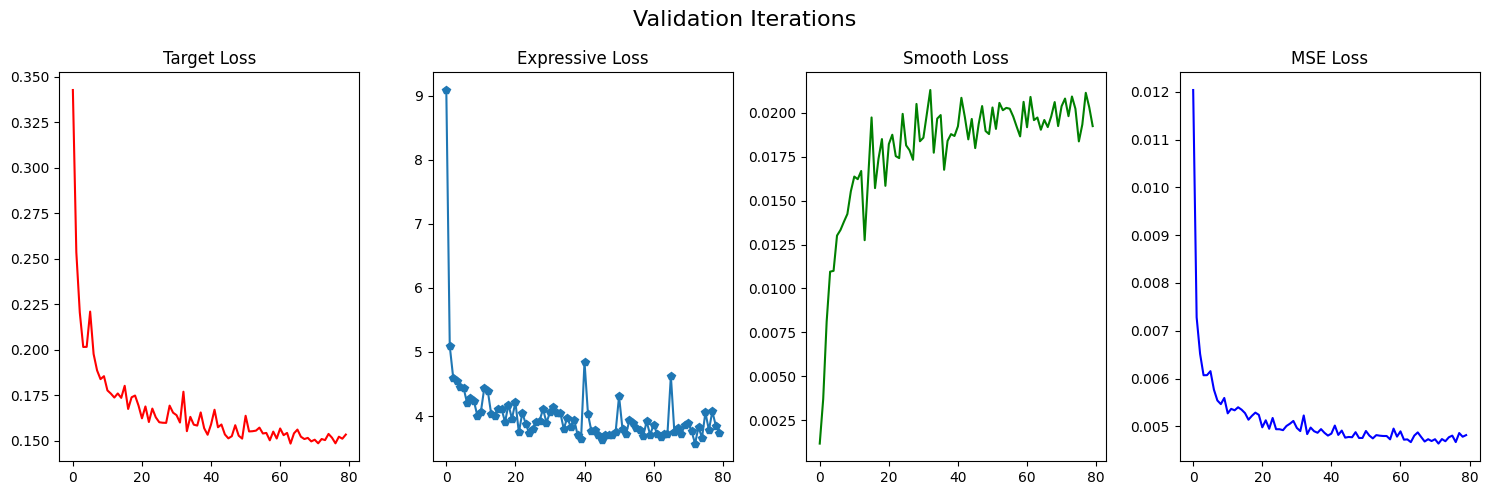

In [21]:
plot_train_val_loss()

### Testing

In [1]:
from pythonosc import udp_client
import time
import sounddevice as sd
import torch
from dataloaders.beat import CustomDataset
from dataloaders.build_vocab import Vocab
import pickle
import numpy as np

config_file = open("camn_config.obj", 'rb') 
args = pickle.load(config_file)
args.batch_size = 16

mean_facial = torch.from_numpy(np.load(args.root_path+args.mean_pose_path+f"{args.facial_rep}/json_mean.npy"))
std_facial = torch.from_numpy(np.load(args.root_path+args.mean_pose_path+f"{args.facial_rep}/json_std.npy"))
mean_audio = torch.from_numpy(np.load(args.root_path+args.mean_pose_path+f"{args.audio_rep}/npy_mean.npy"))
std_audio = torch.from_numpy(np.load(args.root_path+args.mean_pose_path+f"{args.audio_rep}/npy_std.npy"))

In [13]:
test_data = CustomDataset(args, "test")
test_loader = torch.utils.data.DataLoader(
    test_data, 
    batch_size=1,  
    shuffle=True,  
    drop_last=False,
)

In [14]:
data = next(iter(test_loader))

In [15]:
facial = data["facial"]
audio = data["audio"]

In [16]:
out_facial = facial * std_facial + mean_facial
out_audio = audio * std_audio + mean_audio

In [17]:
# Try playing the audio, which is at 16KHZ
print(out_facial.min(), out_facial.max())
print(out_facial.std(), out_facial.mean())

tensor(-2.9796e-09, dtype=torch.float64) tensor(0.6390, dtype=torch.float64)
tensor(0.1029, dtype=torch.float64) tensor(0.1012, dtype=torch.float64)


In [18]:
out_audio.shape

torch.Size([1, 480000])

In [19]:
blend =  [
        "browDownLeft",
        "browDownRight",
        "browInnerUp",
        "browOuterUpLeft",
        "browOuterUpRight",
        "cheekPuff",
        "cheekSquintLeft",
        "cheekSquintRight",
        "eyeBlinkLeft",
        "eyeBlinkRight",
        "eyeLookDownLeft",
        "eyeLookDownRight",
        "eyeLookInLeft",
        "eyeLookInRight",
        "eyeLookOutLeft",
        "eyeLookOutRight",
        "eyeLookUpLeft",
        "eyeLookUpRight",
        "eyeSquintLeft",
        "eyeSquintRight",
        "eyeWideLeft",
        "eyeWideRight",
        "jawForward",
        "jawLeft",
        "jawOpen",
        "jawRight",
        "mouthClose",
        "mouthDimpleLeft",
        "mouthDimpleRight",
        "mouthFrownLeft",
        "mouthFrownRight",
        "mouthFunnel",
        "mouthLeft",
        "mouthLowerDownLeft",
        "mouthLowerDownRight",
        "mouthPressLeft",
        "mouthPressRight",
        "mouthPucker",
        "mouthRight",
        "mouthRollLower",
        "mouthRollUpper",
        "mouthShrugLower",
        "mouthShrugUpper",
        "mouthSmileLeft",
        "mouthSmileRight",
        "mouthStretchLeft",
        "mouthStretchRight",
        "mouthUpperUpLeft",
        "mouthUpperUpRight",
        "noseSneerLeft",
        "noseSneerRight",
        "tongueOut"
    ]

In [20]:
def play_audio(out_audio, init_time):
    time.sleep(init_time - time.time())
    sd.play(out_audio, 16000)
    sd.wait()
    print("Audio finished:", time.time())

In [21]:

def send_udp(out_face, init_time):
    #outWeight = np.zeros(52)

    ##need to implement get value in
    outWeight = out_face

    outWeight = outWeight * (outWeight >= 0)

    client = udp_client.SimpleUDPClient('127.0.0.1', 5008)
    osc_array = outWeight.tolist()
    
    fps = 15
    time.sleep(init_time - time.time())
    #start_time = time.time()
    for i in range(len(osc_array)):
        #print(out_face[i].shape)
        for j, out in enumerate(osc_array[i]):
            client.send_message('/' + str(blend[j]), out)

        elpased_time = time.time() - init_time
        sleep_time = 1.0/fps * (i+1) - elpased_time
        if sleep_time > 0:
            time.sleep(sleep_time)
        #start_time = time.time()
    print("Facial finished:", time.time())

In [38]:
import threading

init_time = time.time() + 1

limit_sec = 20

udp_thread = threading.Thread(target=send_udp, args=(out_facial[0, 0:limit_sec*15],init_time))
udp_thread.daemon = True  # Set the thread as a daemon to allow it to exit when the main program exits

audio_thread = threading.Thread(target=play_audio, args=(out_audio[0, 0:limit_sec*16000],init_time-0.3))
audio_thread.daemon = True

udp_thread.start()
audio_thread.start()

udp_thread.join()
audio_thread.join()

Audio finished: 1715374193.2566211
Facial finished: 1715374193.3603458


In [25]:
print(len(out_audio[0])/16000, len(out_facial[0])/15)

30.0 30.0


In [39]:
 # load in model
from scripts.SimpleNet import FaceGenerator
model_path = 'ckpt_model/simplenet2.pth'
net = FaceGenerator()
net.load_state_dict(torch.load(model_path))
net = net.cuda().eval()

In [40]:
in_audio = audio.cuda()
in_facial = facial.cuda()
pre_frames = 4
in_pre_facial = in_facial.new_zeros((in_facial.shape[0], in_facial.shape[1], in_facial.shape[2] + 1)).cuda() 
in_pre_facial[:, 0:pre_frames, :-1] = in_facial[:, 0:pre_frames]
in_pre_facial[:, 0:pre_frames, -1] = 1 

pred_facial = net(in_pre_facial,in_audio).cpu().detach()
pred_facial = np.array(pred_facial * std_facial + mean_facial)

In [41]:
print(pred_facial.min(), pred_facial.max())
print(pred_facial.std(), pred_facial.mean())

-0.06063432841268339 0.6682312827563855
0.12321689561900993 0.1063973784324082


In [42]:
import threading

init_time = time.time() + 1

limit_sec = 70

udp_thread = threading.Thread(target=send_udp, args=(pred_facial[0,0:limit_sec*15],init_time))
udp_thread.daemon = True  # Set the thread as a daemon to allow it to exit when the main program exits

audio_thread = threading.Thread(target=play_audio, args=(out_audio[0,0:limit_sec*16000],init_time-0.3))
audio_thread.daemon = True

udp_thread.start()
audio_thread.start()

udp_thread.join()
audio_thread.join()

Audio finished: 1715374230.8640478
Facial finished: 1715374230.9936013


In [58]:
print(expressive_loss_function(torch.from_numpy(pred_facial), out_facial))
print(torch.nn.functional.mse_loss(torch.from_numpy(pred_facial), out_facial))

tensor(0.0673, dtype=torch.float64)
tensor(0.0052, dtype=torch.float64)


In [19]:
print(pred_facial.shape)
print(out_facial.shape)

(1, 1680, 51)
torch.Size([1, 1680, 51])


In [22]:
print(pred_facial[:,0,:])

[[ 8.73752973e-03  7.89014494e-03  4.63134123e-01  3.21614527e-01
   3.18027932e-01  4.04698062e-02  3.32072330e-01  3.63076249e-01
  -4.38581960e-04  1.79442354e-03  3.72705275e-02  3.71611128e-02
   2.52829250e-01  7.12454520e-03 -8.49294065e-03  1.61670726e-01
   6.11311772e-02  6.46500007e-02  2.13785962e-01  2.13844659e-01
   6.46099709e-01  6.45870604e-01  9.93512084e-02  2.69829253e-02
   9.15337754e-02  5.23031276e-03  1.44230817e-01  1.06246972e-01
   1.04340959e-01 -1.44008142e-03 -8.50066728e-03  1.88509147e-01
   1.68735657e-03  2.65821328e-01  2.80343588e-01  8.75092674e-02
   9.11398783e-02  8.77053599e-02  2.70951733e-02  1.10258610e-01
   3.39444860e-02  1.29605886e-01  3.04498416e-01  4.63644027e-01
   4.48266173e-01  2.09965860e-01  2.19249496e-01  6.57829263e-02
   8.45406718e-02  1.80118444e-01  2.15634837e-01]]


In [23]:
print(out_facial[:,0,:])

tensor([[-2.9796e-09,  2.9830e-10,  3.9337e-01,  3.0616e-01,  3.0616e-01,
          3.9733e-02,  3.3691e-01,  3.6664e-01,  2.3921e-09, -1.5930e-09,
         -1.6359e-09, -1.9321e-09,  2.8902e-01, -1.2130e-09,  2.0412e-10,
          1.8814e-01,  5.3116e-02,  5.3499e-02,  2.1578e-01,  2.1587e-01,
          6.9715e-01,  6.9714e-01,  9.3386e-02,  3.6447e-02,  1.2060e-01,
         -2.2760e-10,  1.2059e-01,  9.0213e-02,  8.9113e-02,  1.0432e-10,
         -1.1158e-11,  1.8666e-01,  3.4156e-11,  2.7215e-01,  2.8212e-01,
          9.3862e-02,  9.3765e-02,  1.1622e-01,  2.1497e-02,  1.1356e-01,
          4.3822e-02,  1.3656e-01,  3.0891e-01,  5.2099e-01,  5.3139e-01,
          1.8944e-01,  1.8909e-01,  5.9438e-02,  6.6550e-02,  1.5507e-01,
          1.8109e-01]], dtype=torch.float64)
